# Setup and Imports

Imports all the required libraries, custom modules, and environment settings used throughout the notebook.  
It includes dataset utilities, model definitions, sampling utilities, and evaluation metrics for both images and poses.


In [1]:
from dataset import SiTDataset
from tqdm import tqdm
import os
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_S_2, SiT_B_8
import lpips
from PIL import Image
import numpy as np
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

/home/d/dziri/venvs/jlab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Metrics and Utility Functions

Here we define key utility functions and evaluation metrics:

- **PSNR (Peak Signal-to-Noise Ratio):** Measures image quality.
- **LPIPS (Learned Perceptual Image Patch Similarity):** Assesses perceptual similarity between images.
- **MAE (Mean Absolute Error):** Computes the absolute difference between generated and ground-truth images.
- **get_pose_radius:** Calculates the radius of a camera pose for further analysis.


In [2]:
psnr = PeakSignalNoiseRatio(data_range=255).cuda()
lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze').cuda()

def get_pose_radius(pose):
    translation_vector = pose[:3, 3]
    radius = torch.norm(translation_vector)
    
    return radius

def evaluate_prediction(ground_truth, prediction):
    ground_truth = ground_truth.clamp(0, 255)
    prediction = prediction.clamp(0, 255)
    
    psnr_value = psnr(prediction, ground_truth) #(N,C,H,W)

    mae = torch.mean(torch.abs(ground_truth - prediction))

    ground_truth = ground_truth.div(255.0).mul(2).sub(1).clamp(-1, 1)
    prediction = prediction.div(255.0).mul(2).sub(1).clamp(-1, 1)

    lpips_value = lpips(prediction, ground_truth)

    return psnr_value.item(), lpips_value.item(), mae.item()

/home/d/dziri/venvs/jlab/lib/python3.12/site-packages/torchmetrics/functional/image/lpips.py:332: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.lo

# Model and VAE Initialization

This section loads the SiT model and the VAE (Variational Autoencoder) used for encoding and decoding images.  
Model checkpoints are loaded, and all modules are moved to the appropriate computation device (`cuda`).  
Key parameters like latent size and model configuration are set here.


In [7]:
image_size = "128"
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8

model = SiT_B_8(input_size=latent_size, num_classes=1).to('cuda')
state_dict = find_model("results/001-SiT-B-8-Linear-velocity-None/checkpoints/0090000.pt")                # Print the actual tensor (can be large!)
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to('cuda')


# Sampler and Diffusion Process Setup

Defines the configuration for sampling new images using either SDE (Stochastic Differential Equation) or ODE (Ordinary Differential Equation) solvers.  
Parameters for sampling steps, noise, and guidance scale (`cfg_scale`) are established.  
The sampler object is created for use in downstream image generation.


In [8]:
#seed = 1 #@param {type:"number"}
#torch.manual_seed(seed)

num_sampling_steps = 250

cfg_scale = 4

class_labels = [0]
sampler_type = "ODE"

transport = create_transport()
sampler = Sampler(transport)

In [9]:
# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    
    """This tells how strong the noise is"""
    diffusion_norm = 1
    
    """How the final denoised latent should be calculated"""
    last_step = "Mean"
    last_step_size = 0.4
    
    """Final function at the end that does everything:
    """
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5"

    atol = 1e-6
    rtol = 1e-3
    
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )

# Dataset Preparation

Loads the datasets used for training and evaluation.  
Performs necessary preprocessing (resizing, normalization) and computes dataset statistics (mean and std for rotation and translation) required for pose normalization and denormalization.  
Creates DataLoader objects for efficient batch loading during evaluation.


In [11]:
from torchvision import transforms
from torch.utils.data import DataLoader

vae = AutoencoderKL.from_pretrained(vae_model).to("cuda")

device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1], inplace=True)
])

train_dataset = SiTDataset("data/chair_data/train", transform=transform)
rot_mean = torch.Tensor(train_dataset.rotation_mean).to("cuda")
rot_std = torch.Tensor(train_dataset.rotation_std).to("cuda")
trans_mean = torch.Tensor(train_dataset.translation_mean).to("cuda")
trans_std = torch.Tensor(train_dataset.translation_std).to("cuda")

dataset = SiTDataset("data/chair_data/test_div", transform=transform)

eval_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

ys = torch.zeros(1, dtype=torch.long, device="cuda")

# Image Sampling and Evaluation

Samples images from the model using the defined sampler.  
For each batch:
- Images are generated from poses.
- Evaluation metrics (PSNR, LPIPS, MAE) are computed for each sample.
- The first few pairs of ground-truth and predicted images are saved for qualitative comparison.
Aggregates metrics are averaged over the entire evaluation set and printed for summary analysis.


In [12]:
from torchvision.utils import save_image
import torch
from tqdm import tqdm

max_pairs = 10                    # how many GT/pred rows to keep
gt_pool, pred_pool = [], []       # hold first 10 pairs for final sheet

total_psnr = total_mae = total_lpips = 0.0
plot_data = []
radii = []
i = 0
with torch.inference_mode(): 
    for image, gaussian_pose, gt_pose, noise in tqdm(eval_loader, "Evaluating model..."):
        image = image.to("cuda")
        gaussian_pose  = gaussian_pose.to("cuda")
        radius = round(get_pose_radius(gt_pose[0]).item(), 2)
        radii.append(radius)

        n = ys.size(0)
        y = torch.IntTensor([0]).to(device)
        z = torch.cat([gaussian_pose, gaussian_pose], 0)
        y_null = torch.tensor([1] * n, device="cuda")
        y = torch.cat([y, y_null], 0)
        model_kwargs = dict(y=y, cfg_scale=cfg_scale)
    
        samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
        samples = vae.decode(samples / 0.18215).sample
        
        samples = samples[0].unsqueeze(0)
        
        psnr_value, lpips_value, mae = evaluate_prediction(image, samples)
        
        plot_data.append([radius, psnr_value, lpips_value, mae])
        total_psnr += psnr_value
        total_lpips += lpips_value
        total_mae  += mae
        
        if len(gt_pool) < max_pairs:
            gt_pool.append(image[0].cpu())
            pred_pool.append(samples[0].cpu())

        if i == 50:
            break
        else:
            i += 1

if gt_pool:
    sheet_images = torch.stack(
        [im for pair in zip(gt_pool, pred_pool) for im in pair]
    ) 

    save_image(
        sheet_images,
        "gt_vs_pred_first10.png",
        nrow=2,
        padding=2,
        normalize=True,
        value_range=(-1, 1)
    )

num_batches = len(eval_loader)
total_psnr /= num_batches
total_lpips  /= num_batches
total_mae  /= num_batches

print("PSNR:", total_psnr)
print("LPIPS:", total_lpips)
print("MAE: ", total_mae)

Evaluating model...:   2%|▎                   | 50/3000 [00:28<28:03,  1.75it/s]

PSNR: 1.0584213956197104
LPIPS: 8.0259848376348e-06
MAE:  0.0021929557925711076


# Results Visualization

Plots the relationship between camera radius and each evaluation metric (PSNR, LPIPS, MAE) using Matplotlib.  
These visualizations help in analyzing how model performance varies with changes in camera pose.
The resulting figure is saved as an image and displayed inline.


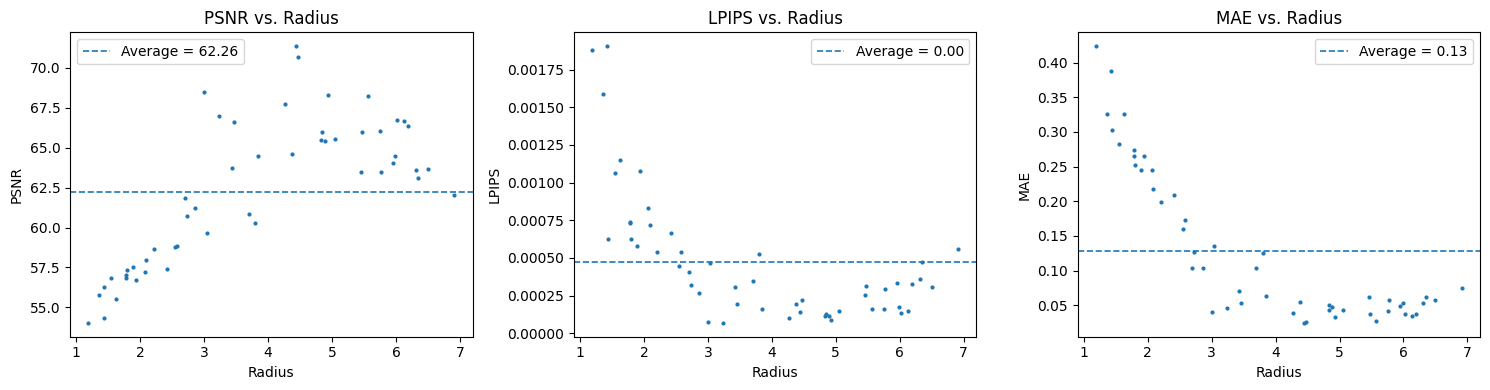

In [13]:
import numpy as np
import matplotlib.pyplot as plt

data   = np.array(plot_data, dtype=float)
data   = data[data[:, 0].argsort()]

radius = data[:, 0]
psnr   = data[:, 1]
lpips    = data[:, 2]
mae    = data[:, 3]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

def add_panel(ax, y, y_label, title):
    ax.plot(radius, y, marker='o', markersize=2, linestyle='none')      # ← changed line
    ax.axhline(y.mean(), ls='--', lw=1.2,
               label=f'Average = {y.mean():.2f}')
    ax.set_xlabel('Radius')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

add_panel(axes[0], psnr, 'PSNR', 'PSNR vs. Radius')
add_panel(axes[1], lpips,  'LPIPS',  'LPIPS vs. Radius')
add_panel(axes[2], mae,  'MAE',  'MAE vs. Radius')

plt.tight_layout()

fig.savefig("radius_metrics.png", dpi=300, bbox_inches="tight")

plt.show()


# Test Invertibility of SiT
Tests the invertibility property of the SiT model—recovering camera pose information from images.  
This section is essential for applications like general pose estimation or evaluating the model on turntable (360°) datasets.


In [14]:
from dataset import SiTDataset
from tqdm import tqdm
import os
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_S_2, SiT_B_8
import lpips
from PIL import Image
import numpy as np
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [15]:
image_size = "128"
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8

model = SiT_B_8(input_size=latent_size, num_classes=1).to('cuda')
state_dict = find_model("results/001-SiT-B-8-Linear-velocity-None/checkpoints/0090000.pt")                # Print the actual tensor (can be large!)
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to('cuda')

# Inverse Sampler and Dataset Setup

Initializes the model, VAE, and sampling routine for the inverse task (pose extraction from images).  
Loads the specific test dataset and sets up all required normalization statistics.


In [16]:
#seed = 1 #@param {type:"number"}
#torch.manual_seed(seed)

num_sampling_steps = 250

cfg_scale = 4

class_labels = [0]
sampler_type = "ODE"

transport = create_transport()
sampler = Sampler(transport)

In [17]:
# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    
    """This tells how strong the noise is"""
    diffusion_norm = 1
    
    """How the final denoised latent should be calculated"""
    last_step = "Mean"
    last_step_size = 0.4
    
    """Final function at the end that does everything:
    """
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
        reverse=True
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5" 

    atol = 1e-6
    rtol = 1e-3
    
    sample_fn = sampler.sample_ode_backwards(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps,
        reverse=False
    )

In [18]:
from torchvision import transforms
from torch.utils.data import DataLoader

vae = AutoencoderKL.from_pretrained(vae_model).to("cuda")

device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1], inplace=True)
])

train_dataset = SiTDataset("data/chair_data/train", transform=transform)
rot_mean = torch.Tensor(train_dataset.rotation_mean).to("cuda")
rot_std = torch.Tensor(train_dataset.rotation_std).to("cuda")
trans_mean = torch.Tensor(train_dataset.translation_mean).to("cuda")
trans_std = torch.Tensor(train_dataset.translation_std).to("cuda")

dataset = SiTDataset("data/chair_data/circle_test", transform=transform)

eval_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

ys = torch.zeros(1, dtype=torch.long, device="cuda")

# Pose Extraction, Error Computation, and Evaluation

Defines utility functions for reconstructing camera poses from denoised latents and evaluating translation and rotation errors.  
Iterates over the evaluation dataset, extracts predicted poses, compares them to ground-truth, and accumulates errors for final summary statistics.


In [19]:
import torch
import numpy as np
import torch

def extract_original_pose(denoised_pose, rot_mean, rot_std, trans_mean, trans_std):
    
    """
    Reconstruct the original 4x4 pose from the denoised 4x16x16 tensor.
    Handles standardized rotation and translation separately.
    """
    stdized_pose_flat = []

    for i in range(4):
        first = torch.mean(denoised_pose[i, :8, :8])
        second = torch.mean(denoised_pose[i, :8, 8:])
        third = torch.mean(denoised_pose[i, 8:, :8])
        fourth = torch.mean(denoised_pose[i, 8:, 8:])
        stdized_pose_flat.extend([first, second, third, fourth])

    stdized_pose_tensor = torch.stack(stdized_pose_flat)

    original_flat = stdized_pose_tensor.clone()

    rot_indices = [0, 1, 2, 4, 5, 6, 8, 9, 10]
    trans_indices = [3, 7, 11]

    # Extract standardized components
    R_std = stdized_pose_tensor[rot_indices]
    t_std = stdized_pose_tensor[trans_indices]

    # De-standardize
    R = R_std * rot_std + rot_mean
    t = t_std * trans_std + trans_mean

    # Re-insert into flat array
    for i, idx in enumerate(rot_indices):
        original_flat[idx] = R[i]
    for i, idx in enumerate(trans_indices):
        original_flat[idx] = t[i]

    original_flat[12:16] = torch.tensor([0., 0., 0., 1.], dtype=original_flat.dtype)

    # Reshape back to 4x4
    pose_4x4 = original_flat.view(4, 4)

    return pose_4x4

def calculate_translation_error(ground_truth, prediction):
    prediction = prediction.to("cuda")
    ground_truth_translation = ground_truth[0:3, 3]
    prediction_translation = prediction[0:3, 3]
    
    distance = torch.sqrt(torch.sum(torch.pow(torch.subtract(ground_truth_translation, prediction_translation), 2), dim=0)) 

    return distance.item()

def calculate_rotation_error(ground_truth, prediction):
    ground_truth = ground_truth.to("cuda")
    prediction = prediction.to("cuda")
    
    ground_truth_rotation = ground_truth[:3, :3]
    prediction_rotation = prediction[:3, :3]
    prediction_rotation = prediction_rotation.type(torch.FloatTensor).to("cuda")

    dot_product = ground_truth_rotation.T @ prediction_rotation

    trace = torch.trace(dot_product)

    cos_arg = torch.clamp((trace - 1) / 2, -1.0, 1.0)

    result = torch.acos(cos_arg)

    result_deg = torch.rad2deg(result)

    return result_deg.item()

def evaluate_poses(ground_truth, prediction):

    translation_error = calculate_translation_error(ground_truth, prediction)

    rotation_error = calculate_rotation_error(ground_truth, prediction)
    
    return translation_error, rotation_error

In [21]:
#Iterate over testset loader, get image, pose
total_translation_error = 0
total_rotation_error = 0
plot_data = []
pose_gt = []
pose_pred = []

i = 0
for image, gaussian_pose, gt_pose, noise in tqdm(eval_loader, "Evaluating model..."):

    noise = noise.to("cuda")[0]
    gaussian_pose = gaussian_pose.to("cuda")
    gt_pose = gt_pose.to("cuda")
    
    image = image.to("cuda")
    posterior = vae.encode(image)[0]
    image = posterior.sample()
    image = image * 0.18215
    
    n = ys.size(0)
    y = torch.IntTensor([0]).to(device)
    z = torch.cat([image, image], 0)
    y_null = torch.tensor([1] * n, device="cuda")

    y = torch.cat([y, y_null], 0)
    model_kwargs = dict(y=y, cfg_scale=cfg_scale)

    samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]

    #HERE was the error, I had samples = samples[0][0]

    denoised_pose = samples - noise
    
    reconstructed_pose = extract_original_pose(denoised_pose, rot_mean, rot_std, trans_mean, trans_std)
    
    pose_pred.append(reconstructed_pose.cpu().detach().numpy())
    pose_gt.append(gt_pose[0].cpu().detach().numpy())

    if i == 50:
        break
    else:
        i += 1 
    
    translation_error, rotation_error = evaluate_poses(gt_pose[0], reconstructed_pose)
    
    total_translation_error += translation_error
    total_rotation_error += rotation_error

total_translation_error /= eval_loader.__len__()
total_rotation_error /= eval_loader.__len__()

print("translation error:", total_translation_error)
print("rotation_error:", total_rotation_error)

Evaluating model...:   5%|█                   | 50/1000 [01:43<32:50,  2.07s/it]

translation error: 0.06818159712851048
rotation_error: 0.813331039428711


# Pose Visualization

Visualizes the predicted and ground-truth camera poses in 3D using Matplotlib.  
Shows both coordinate frames and camera origins for a clear qualitative assessment of the model's performance on pose recovery.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw_coordinate_frame(ax, pose, length=0.1, color_set=('r', 'g', 'b')):

    origin = pose[:3, 3]
    x_axis = pose[:3, 0] * length
    y_axis = pose[:3, 1] * length
    z_axis = pose[:3, 2] * length

    ax.quiver(*origin, *x_axis, color=color_set[0])
    ax.quiver(*origin, *y_axis, color=color_set[1])
    ax.quiver(*origin, *z_axis, color=color_set[2])

def visualize_poses(gt_poses, pred_poses):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    gt_origins = []
    pred_origins = []

    for pose in gt_poses:
        draw_coordinate_frame(ax, pose, color_set=('cyan', 'blue', 'navy'))
        gt_origins.append(pose[:3, 3])

    for pose in pred_poses:
        draw_coordinate_frame(ax, pose, color_set=('orange', 'red', 'darkred'))
        pred_origins.append(pose[:3, 3])

    gt_origins = np.array(gt_origins)
    pred_origins = np.array(pred_origins)

    ax.scatter(gt_origins[:, 0], gt_origins[:, 1], gt_origins[:, 2],
               c='blue', s=25, label='Ground Truth')
    ax.scatter(pred_origins[:, 0], pred_origins[:, 1], pred_origins[:, 2],
               c='red', s=25, label='Predicted')

    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([-5, 5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Ground Truth vs Predicted Poses")
    ax.view_init(elev=50, azim=20)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

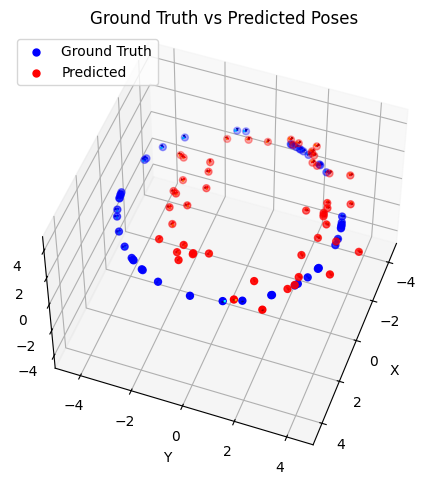

In [24]:
visualize_poses(pose_gt, pose_pred)